# Project Description: "Needs to be completed"

## How to load and format data was taking from: https://colab.research.google.com/github/trekhleb/machine-learning-experiments/blob/master/experiments/rock_paper_scissors_cnn/rock_paper_scissors_cnn.ipynb#scrollTo=DJ8jGFnTLt8t

### Un-comment and run if your environment is missing tensorflow datasets package.

In [82]:
# ! pip install tensorflow_datasets

In [83]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

In [84]:
# Load the Rock Paper Scissors dataset
dataset = tfds.load('rock_paper_scissors')

# Split the dataset into training and testing sets
train_dataset = dataset['train']
test_dataset = dataset['test']

In [85]:
# number of samples to reduce size of model
#num_samples = 1000

# Take a subset of the training dataset
#train_dataset = train_dataset.take(num_samples)

### Data Exploration:

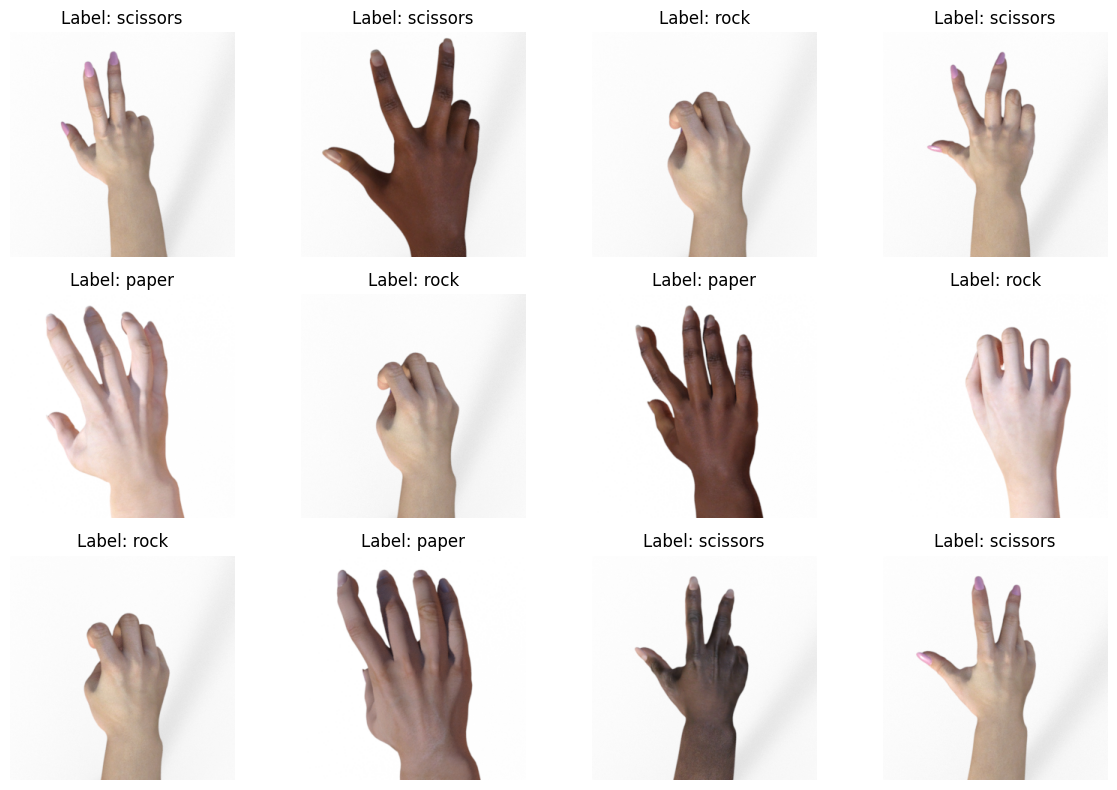

In [86]:
# Define the label names
label_names = ['rock', 'paper', 'scissors']

# Take 12 random samples from the training dataset
num_samples = 12
samples = train_dataset.shuffle(1000).take(num_samples)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))

# Iterate over the samples and plot the images
for i, data in enumerate(samples):
    image = data['image']
    label = data['label']

    # Convert the image tensor to a NumPy array
    image_array = tf.image.convert_image_dtype(image, tf.uint8).numpy()

    # Calculate the subplot position
    row = i // 4
    col = i % 4

    # Plot the image in the corresponding subplot
    axes[row, col].imshow(image_array)
    axes[row, col].set_title(f"Label: {label_names[label.numpy()]}")
    axes[row, col].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

### Pre-Process data

In [87]:
def preprocess_image(data):
    image = tf.image.resize(data['image'], (128, 128))
    image = tf.cast(image, tf.float32) / 255.0
    label = data['label']
    return image, label

train_dataset = train_dataset.map(preprocess_image)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = test_dataset.map(preprocess_image)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [88]:
# Define the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [89]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 63504)             0         
                                                                 
 dense_6 (Dense)             (None, 32)                2032160   
                                                                 
 dense_7 (Dense)             (None, 3)                 99        
                                                                 
Total params: 2,032,707
Trainable params: 2,032,707
Non-trainable params: 0
____________________________________________

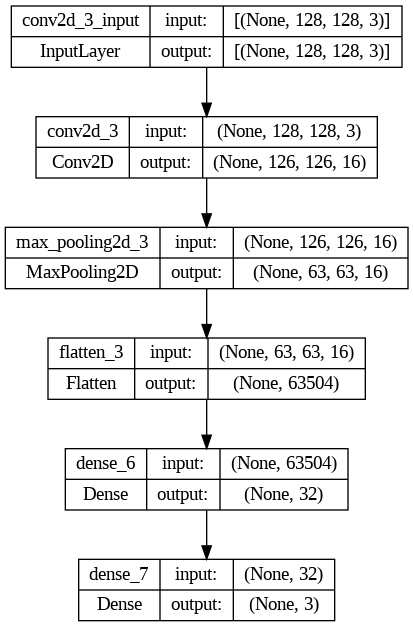

In [90]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

In [91]:
# we can also add learning rate to optimizer
# adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


# Compile cnn model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [92]:

# Train cnn mmodel
model.fit(train_dataset, epochs=10)

Epoch 1/10
79/79 [==============================] - 8s 72ms/step - loss: 1.2235 - accuracy: 0.6294
Epoch 2/10
79/79 [==============================] - 1s 12ms/step - loss: 0.3984 - accuracy: 0.9202
Epoch 3/10
79/79 [==============================] - 1s 11ms/step - loss: 0.1409 - accuracy: 0.9873
Epoch 4/10
79/79 [==============================] - 1s 11ms/step - loss: 0.0687 - accuracy: 0.9933
Epoch 5/10
79/79 [==============================] - 1s 11ms/step - loss: 0.0381 - accuracy: 0.9984
Epoch 6/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0247 - accuracy: 0.9988
Epoch 7/10
79/79 [==============================] - 1s 19ms/step - loss: 0.0171 - accuracy: 0.9992
Epoch 8/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0123 - accuracy: 0.9996
Epoch 9/10
79/79 [==============================] - 1s 11ms/step - loss: 0.0092 - accuracy: 0.9996
Epoch 10/10
79/79 [==============================] - 1s 12ms/step - loss: 0.0069 - accuracy: 0.9996


In [93]:
# Evaluate cnn model
model.evaluate(test_dataset)

12/12 [==============================] - 1s 65ms/step - loss: 1.0571 - accuracy: 0.6774


[1.057130217552185, 0.6774193644523621]

In [94]:
# save cnn model
#model_name = 'rock_paper_scissors_cnn.h5'
#model.save(model_name, save_format='h5')

## Finetunning: (Needs to be done)
### Train data is overfitting and test accuracy is low. Change parameters. See attached google notebook for optimal parameters. Also, pre-processing may need to be optimized as well, pre-processing imput shape, etc. Again, see notebook from google colab referenced at beginning of notebook.

### Fix overfitting my augmenting data. This include rotating images, flipping images, changing color, and zoom. Augmentations taken from: https://www.wouterbulten.nl/posts/data-augmentation-using-tensorflow-data-dataset/

In [95]:
def flip(x: tf.Tensor) -> tf.Tensor:
    """Flip augmentation

    Args:
        x: Image to flip

    Returns:
        Augmented image
    """
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)

    return x

In [96]:
def color(x: tf.Tensor) -> tf.Tensor:
    """Color augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """
    x = tf.image.random_hue(x, 0.08)
    x = tf.image.random_saturation(x, 0.6, 1.6)
    x = tf.image.random_brightness(x, 0.05)
    x = tf.image.random_contrast(x, 0.7, 1.3)
    return x

In [97]:
def rotate(x: tf.Tensor) -> tf.Tensor:
    """Rotation augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    return tf.image.rot90(x, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))

In [98]:
def zoom(x: tf.Tensor) -> tf.Tensor:
    """Zoom augmentation

    Args:
        x: Image

    Returns:
        Augmented image
    """

    # Generate 20 crop settings, ranging from a 1% to 20% crop.
    scales = list(np.arange(0.8, 1.0, 0.01))
    boxes = np.zeros((len(scales), 4))

    for i, scale in enumerate(scales):
        x1 = y1 = 0.5 - (0.5 * scale)
        x2 = y2 = 0.5 + (0.5 * scale)
        boxes[i] = [x1, y1, x2, y2]

    def random_crop(img):
        # Create different crops for an image
        crops = tf.image.crop_and_resize([img], boxes=boxes, box_indices=np.zeros(len(scales)), crop_size=(32, 32))
        # Return a random crop
        return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]


    choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)

    # Only apply cropping 50% of the time
    return tf.cond(choice < 0.5, lambda: x, lambda: random_crop(x))

### Zoom not implemented. Need to fix error at a later point.

In [99]:
def augment_data(image, label):
    image = flip(image)
    image = color(image)
    image = rotate(image)
    #image = zoom(image)
    return image, label

In [100]:
train_dataset_augmented = train_dataset.map(augment_data)

### Explore new augmented dataset

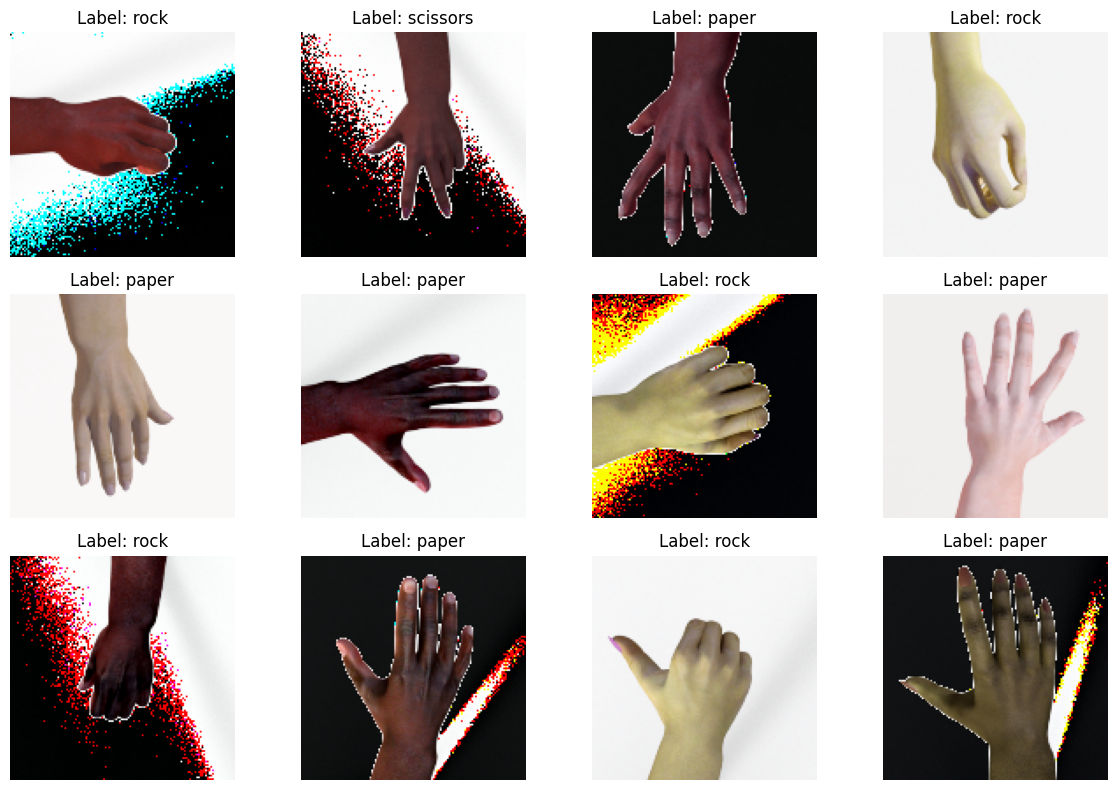

In [101]:
# Explore augmented training dataset.

# Take 12 random samples from the augmented training dataset
num_samples = 12
samples = train_dataset_augmented.shuffle(1000).take(num_samples)

# Create a grid of subplots
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 8))

# Iterate over the samples and plot the images
for i, (image, label) in enumerate(samples):
    # Select a single image from the batch
    image = image[0]

    # Convert the image tensor to a NumPy array
    image_array = tf.image.convert_image_dtype(image, tf.uint8).numpy()

    # Calculate the subplot position
    row = i // 4
    col = i % 4

    # Plot the image in the corresponding subplot
    axes[row, col].imshow(image_array)
    axes[row, col].set_title(f"Label: {label_names[label[0].numpy()]}")
    axes[row, col].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

# Shuffle and batch the datasets so a few samples from each is taken for training.

In [102]:
def preprocess_image_augmented(image,label):
    image = tf.image.resize(data['image'], (128, 128))
    image = tf.cast(image, tf.float32) / 255.0
    label = data['label']
    return image, label

train_dataset_augmented = train_dataset_augmented.map(preprocess_image_augmented)
train_dataset_augmented = train_dataset_augmented.batch(32).prefetch(tf.data.AUTOTUNE)

In [103]:
# combine the datasets
# Combine the augmented and original training datasets
combined_train_dataset = train_dataset_augmented.concatenate(train_dataset)

# Shuffle the combined dataset
#combined_train_dataset = combined_train_dataset.shuffle(1000)

# Batch and prefetch the combined dataset
#combined_train_dataset = combined_train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)


In [104]:
# Shuffle and batch the datasets
#batch_size = 32
#train_dataset_augmented = train_dataset_augmented.shuffle(1000).batch(batch_size)
#train_dataset = train_dataset.shuffle(1000).batch(batch_size)
#test_dataset = test_dataset.batch(batch_size)

In [105]:
# Train the model using the combined dataset
epochs = 10
model.fit(combined_train_dataset, epochs=epochs, verbose=1)

Epoch 1/10
82/82 [==============================] - 4s 35ms/step - loss: 0.0056 - accuracy: 1.0000
Epoch 2/10
82/82 [==============================] - 4s 42ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 3/10
82/82 [==============================] - 4s 30ms/step - loss: 0.0032 - accuracy: 1.0000
Epoch 4/10
82/82 [==============================] - 3s 27ms/step - loss: 0.0026 - accuracy: 1.0000
Epoch 5/10
82/82 [==============================] - 3s 27ms/step - loss: 0.0021 - accuracy: 1.0000
Epoch 6/10
82/82 [==============================] - 3s 27ms/step - loss: 0.0018 - accuracy: 1.0000
Epoch 7/10
82/82 [==============================] - 4s 36ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 8/10
82/82 [==============================] - 3s 29ms/step - loss: 0.0014 - accuracy: 1.0000
Epoch 9/10
82/82 [==============================] - 3s 29ms/step - loss: 0.0012 - accuracy: 1.0000
Epoch 10/10
82/82 [==============================] - 4s 29ms/step - loss: 0.0010 - accuracy: 1.0000


In [106]:
# Evaluate cnn model
model.evaluate(test_dataset)

12/12 [==============================] - 0s 10ms/step - loss: 1.3514 - accuracy: 0.6828


[1.3514119386672974, 0.6827957034111023]

In [107]:
# save cnn model
model_name = 'rock_paper_scissors_cnn.h5'
model.save(model_name, save_format='h5')